# Plan



Generate some low dimensional dynamics
Then add space on top of that




In [2038]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.optimize as op
import sys
import scipy as sp
import numba
from functools import partial
from mpl_toolkits import mplot3d
from sympy import Matrix
seaborn.set(font_scale=1.5,style='ticks')

In [2121]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# Run with jax

In [2122]:
dim = 4
nT = 9
x0 = np.random.normal(size=(dim,1))
A_ = np.random.normal(size=(dim,dim))

A = np.zeros([dim,dim])

for i in range(dim):
    A[i,i:] = A_[i:,i]
    A[i:,i] = -A_[i:,i]
    
A[np.diag_indices_from(A)] = 0
A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)

x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(9)])

In [2123]:
Ahat = np.random.normal(size=(dim,dim))


In [2124]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random


In [2125]:
def get_basis_tensor(dim):
    """ Returns a tensor that forms a basis for skew symmetric matrices.
        Use np.einsum('i...,i...',params,basis_tensor) to construct this
        matrix
    """
    basis_tensor = []
    for i in range(dim):
        for j in range(i+1,dim):
            bi =  np.zeros([dim,dim])
            bi[i,j] = -1
            bi = bi -bi.T
            basis_tensor.append(bi.T)
    basis_tensor = np.array(basis_tensor)
    return np.asarray(basis_tensor)


In [2126]:
def construct_M(skewM,dim):
    """ Perform Caley transform"""
    return (jnp.eye(dim) - skewM)@jnp.linalg.inv(jnp.eye(dim)+skewM)

In [2127]:
def predict(T,x,y,n,dim):
    transition_matrix = jnp.reshape(T,(dim,dim))
    return jnp.sum((jnp.dot(jnp.linalg.matrix_power(transition_matrix,n),x)-y)**2)


#predict_funs = [partial(predict,n=i,dim=dim) for i in range(9)]
#grad_predict_funs = [grad(i) for i in predict_funs]

In [2128]:
def predict_all(params,x,dim,basis_tensor):

    err = 0
    nT = len(x)
    k = 0
    skewM = jnp.einsum('i...,i...',params,basis_tensor)
    M = construct_M(skewM,dim)
    #print(M.shape)
    for start_state in range(nT):
        for pred_state in range(start_state+1,nT-start_state):
            n_fwd = pred_state-start_state 
            err += predict(M,x[start_state],x[pred_state],n_fwd,dim)
            k += 1
    mse = err/k
    #print(mse)
    return mse


In [2129]:
def grad_wrapper(params,x,dim,basis_tensor):
    grad = grad_predict_all(jnp.array(params),x,dim,basis_tensor)
    grad = np.array(grad)
    print(grad)
    return grad

In [2130]:
def caley_transform(skewM,dim):
    """ Perform Caley transform"""
    return (np.eye(dim) - skewM)@np.linalg.inv(np.eye(dim)+skewM)

## Generate Data

# Get this to work with cell activity with structured noise

In [2131]:
n_neurons = 120
dim = 7
nT = 9

frac_noise_dynamics = .9

x0 = np.random.normal(size=(dim,1))
x0_2 = np.random.normal(size=(dim,1))


a_params = np.random.normal(size=int(dim*(dim-1)/2))

basis_tensor = get_basis_tensor(dim)
skewM = np.einsum('i...,i...',a_params,basis_tensor)
A = caley_transform(skewM,dim)

#A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)
x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(nT)])
x_2 = np.array([np.linalg.matrix_power(A,i)@x0_2 for i in range(nT)])

x = frac_noise_dynamics*x + (1-frac_noise_dynamics)*np.random.normal(size=x.shape)
x_2 = frac_noise_dynamics*x_2 + (1-frac_noise_dynamics)*np.random.normal(size=x.shape)


W = np.random.normal(size=(n_neurons,dim))
basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [2132]:
skewM==-skewM.T

array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True]])

In [2133]:
def get_spatial_tuning(poke_pos,peak_loc,width):
    """"""
    #for i in range(9):
    distance_matrix = np.abs((poke_pos[peak_loc]-poke_pos)**2).sum(axis=1)
    fr = norm(scale=width).pdf(distance_matrix)
    return fr#distance_matrix
        
def get_task_tuning_line(seq,peak_loc,width):
    task_dists = np.abs(peak_loc-np.arange(9))
#     fr = norm(scale=width).pdf(task_dists)
    fr = np.sin(task_dists)
    return fr[seq]#task_dists[seq]#[task_dists[i] for i in seq]#fr#[fr[i] for i in seq]

In [2134]:
from scipy.stats import norm


act_matrix = []
act_matrix2 = []
space_order2 = np.random.permutation(np.arange(9))
for nix in range(n_neurons):
    
    frac_space = np.random.uniform(0,1)
    peak_space = np.random.randint(0,9)
    std_space = np.random.randint(1000,12000)
    
    lamda1 = get_spatial_tuning(poke_pos,peak_space,std_space)
    lamda1 = lamda1/np.max(lamda1)
    
    lamda2 = np.squeeze(x)@np.random.normal(size=dim)
    lamda2_2 = np.squeeze(x_2)@np.random.normal(size=(dim))

    
    w1 = np.random.normal()
    w2 = np.random.normal()
    activity = frac_space*lamda1 + (1-frac_space)*lamda2# + np.random.normal(scale=.1,size=9)
    act_matrix.append(activity.copy())
    
    activity2 = lamda1[space_order2] + lamda2_2
    act_matrix2.append(activity2.copy())
act_matrix = np.array(act_matrix).T
act_matrix2 = np.array(act_matrix2).T

In [2135]:
np.linalg.norm(A,axis=0)

array([1., 1., 1., 1., 1., 1., 1.])

In [2136]:
evals, evecs = np.linalg.eig(A)

In [2137]:
#Adash = Matrix(A)
#P,J = Adash.jordan_form()

In [2138]:
x.shape

(9, 7, 1)

In [2139]:
evals

array([ 1.        +0.j        , -0.41807199+0.9084139j ,
       -0.41807199-0.9084139j , -0.74740709+0.66436635j,
       -0.74740709-0.66436635j, -0.94419147+0.32939712j,
       -0.94419147-0.32939712j])

In [2140]:
u1 = (evecs[:,0] + evecs[:,1]).real
u2 = (1j*(evecs[:,0] - evecs[:,1])).real

In [2141]:
evals

array([ 1.        +0.j        , -0.41807199+0.9084139j ,
       -0.41807199-0.9084139j , -0.74740709+0.66436635j,
       -0.74740709-0.66436635j, -0.94419147+0.32939712j,
       -0.94419147-0.32939712j])

0
1
2


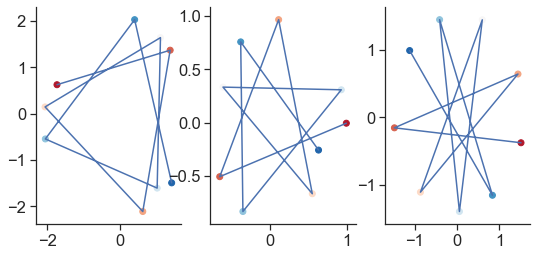

In [2142]:
plt.figure(figsize=(12,4))
offset = 0
if np.isreal(evals[0]): offset = 1
for i in range(int(np.floor(dim/2))):
    print(i)
    plt.subplot(1,4,i+1)
    ix0 = (2*i)     + offset
    ix1 = (2*i + 1) + offset
    u1 = (evecs[:,ix0] + evecs[:,ix1]).real
    u1 = u1/np.linalg.norm(u1)
    u2 = (1j*(evecs[:,ix0] - evecs[:,ix1])).real
    u2 = u2/np.linalg.norm(u2)
    w = np.vstack([u1,u2]).T
    projection = (np.squeeze(x)@w).T
    plt.plot(*(projection))
    plt.scatter(projection[0],projection[1],c=seaborn.color_palette("RdBu_r",n_colors=9))

seaborn.despine()

In [2153]:
def calculate_variance_explained_2(wx,x,cov=None):
    """
    USE THIS VERSION ITS MUCH CLEARER
    https://stats.stackexchange.com/questions/8630/principal-component-analysis-backwards-how-much-variance-of-the-data-is-expla
    """
    wx = np.reshape(wx,[-1,1])
    if cov is None:
        cov = np.cov(x)
    return (wx.T@cov@wx)/np.trace(cov)
    


In [2154]:
ix0 = 1
ix1 = 2
u1 = (evecs[:,ix0] + evecs[:,ix1]).real
u1 = u1/np.linalg.norm(u1)
u2 = (1j*(evecs[:,ix0] - evecs[:,ix1])).real
u2 = u2/np.linalg.norm(u2)


In [2155]:
(calculate_variance_explained_2(u1,np.squeeze(x).T) + 
 calculate_variance_explained_2(u2,np.squeeze(x).T) )


array([[0.58054362]])

In [2156]:
calcualte_variance_explained_by_projection(u1,np.squeeze(x).T)

array([[0.30669355]])

In [2149]:
def calcualte_variance_explained_by_projection(wx,x,cov=None):
    """ This is a bit strange it makes sense from a logical point
        of view in"""
    if cov is None:
        cov = np.cov(x)
    wx = np.reshape(wx,[-1,1])
    #print(np.linalg.norm(wx))
    #if 
    top = np.linalg.norm(cov@wx)**2 #the same as np.sum((cov@w[:,0])**2)
    bottom = (wx.T@cov@wx) * np.trace(cov)
    explained_variance_ratio = top/bottom
    
    return explained_variance_ratio

In [2150]:
np.corrcoef((np.squeeze(x)@w).T)

array([[ 1.        , -0.03633504],
       [-0.03633504,  1.        ]])

In [2151]:
np.cov(np.squeeze(x)-np.mean(np.squeeze(x),axis=1)[:,None])[0]

array([ 1.13080036, -0.90158253,  0.08537443,  0.42996631, -0.12229717,
       -0.43836251,  0.51737901,  0.12084742, -0.78167176])

In [2152]:
(calcualte_variance_explained_by_projection(u1,np.squeeze(x).T) + 
 calcualte_variance_explained_by_projection(u2,np.squeeze(x).T)
)

array([[0.62089124]])

In [2077]:
from sklearn.decomposition import PCA

In [2078]:
pca = PCA(n_components=3)

In [2079]:
pca.fit_transform(np.squeeze(x))

array([[-2.76056818,  1.59804105, -0.64457469],
       [ 1.1473567 ,  2.82476142,  0.96729604],
       [ 2.89036622, -0.58401858, -0.56785056],
       [-0.14649506, -2.70000766, -0.73794132],
       [-2.56286858, -0.64576801,  1.88936428],
       [-1.28715973,  2.4178769 , -0.60075545],
       [ 2.40903529,  1.76498955, -0.54318817],
       [ 2.36555491, -2.24886358,  1.02015384],
       [-2.05522156, -2.42701108, -0.78250396]])

In [2080]:
pca.explained_variance_ratio_[0]

0.43076511453737765

In [2081]:
calcualte_variance_explained_by_projection(wx=pca.components_[0],x=np.squeeze(x).T)

array([[0.43076511]])

In [2082]:
calcualte_variance_explained_by_projection(wx=pca.components_[0],x=np.squeeze(x).T)

array([[0.43076511]])

In [2083]:
w.shape

(7, 2)

In [2084]:
np.sum(pca.explained_variance_ratio_[0]*np.var(x,axis=0))

4.573461556231648

In [2085]:
pca.explained_variance_ratio_[0]

0.43076511453737765

In [2086]:
calcualte_variance_explained_by_projection(wx=pca.components_[0],x=np.squeeze(x).T)

array([[0.43076511]])

In [2087]:
pca.explained_variance_[0]

5.145144250760608

In [2088]:
cov.shape

(3, 3)

In [2089]:
np.linalg.norm(cov@pca.components_[:,0].reshape([-1,1]))

0.025574611498822793

In [2090]:
w.shape

(7, 2)

In [2094]:
w.shape

(7, 2)

In [2095]:
x.shape

(9, 7, 1)

In [2098]:
cov = np.cov(np.squeeze(x).T)

np.linalg.norm(cov@w)/np.sum(np.trace(cov) + w.T@cov@w)

0.03303135696813872

In [2099]:
cov.shape

(7, 7)

In [2100]:
w.shape

(7, 2)

In [2102]:
evals, evecs = np.linalg.eig(A)

In [2103]:
real_evec = int(np.where(np.isreal(evals))[0])
nullspace = sp.linalg.null_space(evecs[:,real_evec].reshape(1,-1))
lns = np.linspace(-2,2,num=2)
xx, yy = np.meshgrid(lns,lns)
z = np.einsum('ij,klj->kli',nullspace,np.dstack([xx,yy])) + np.squeeze(np.mean(x,axis=0))[None,None]

# plot the plane
#ax.plot_surface(xx, yy, z, alpha=0.5)


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (7,6)->(7,6) (2,2,2)->(2,2,newaxis,2) 

In [2104]:
np.mean(x,axis=0)

array([[ 0.35123731],
       [-0.24139341],
       [ 0.15914824],
       [-0.57619474],
       [ 0.07154751],
       [-0.23843593],
       [-0.32326363]])

In [2105]:
evals

array([ 1.        +0.j        ,  0.18363189+0.98299508j,
        0.18363189-0.98299508j, -0.79266727+0.60965449j,
       -0.79266727-0.60965449j, -0.63285785+0.774268j  ,
       -0.63285785-0.774268j  ])

In [2106]:
(-1*nullspace[:,0] + -1*nullspace[:,1])

array([-0.03905586+0.j, -0.99275218+0.j, -1.0061655 +0.j,  0.01664151+0.j,
       -0.00206354+0.j,  0.01150217+0.j,  0.01162903+0.j])

In [2107]:
xx[0,0]

-2.0

In [2108]:
np.sum(-1*nullspace[:,0] + -1*nullspace[:,1])

(-2.0002643691856283+0j)

In [2109]:
np.allclose(0,evecs[:,0].reshape(1,-1)@nullspace)

True

In [2110]:
evals

array([ 1.        +0.j        ,  0.18363189+0.98299508j,
        0.18363189-0.98299508j, -0.79266727+0.60965449j,
       -0.79266727-0.60965449j, -0.63285785+0.774268j  ,
       -0.63285785-0.774268j  ])

In [2111]:
nullspace

array([[ 0.26154011-0.j, -0.22248425-0.j,  0.60051501-0.j,
        -0.07446361-0.j,  0.41506011-0.j,  0.41963798-0.j],
       [ 0.95146453-0.j,  0.04128765-0.j, -0.11144095-0.j,
         0.01381863-0.j, -0.07702504-0.j, -0.07787458-0.j],
       [ 0.04128765-0.j,  0.96487784-0.j,  0.09479944-0.j,
        -0.01175509-0.j,  0.06552287-0.j,  0.06624554-0.j],
       [-0.11144095-0.j,  0.09479944-0.j,  0.74412353-0.j,
         0.03172858-0.j, -0.17685506-0.j, -0.17880566-0.j],
       [ 0.01381863-0.j, -0.01175509-0.j,  0.03172858-0.j,
         0.99606567-0.j,  0.02192995-0.j,  0.02217183-0.j],
       [-0.07702504-0.j,  0.06552287-0.j, -0.17685506-0.j,
         0.02192995-0.j,  0.87776246-0.j, -0.12358575-0.j],
       [-0.07787458-0.j,  0.06624554-0.j, -0.17880566-0.j,
         0.02217183-0.j, -0.12358575-0.j,  0.87505117-0.j]])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 7

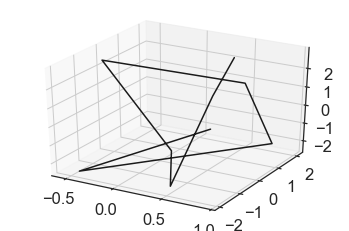

In [2112]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(x[:,0,0],x[:,1,0],x[:,2,0],color='k')

ax.plot3D(*np.vstack([np.zeros(3),evecs[:,real_evec]]).T,color='r')
#ax.plot3D(*np.vstack([np.zeros(3),evecs[:,1]]).T)
#ax.plot3D(*np.vstack([np.zeros(3),evecs[:,2]]).T)
ax.plot3D(*np.vstack([np.zeros(3),nullspace[:,0].real]).T,color='g')
ax.plot3D(*np.vstack([np.zeros(3),nullspace[:,1].real]).T,color='g')

#ax.set_xlim(-1,1)
#ax.set_ylim(-1,1)
#ax.set_zlim(-1,1)
ax.plot_surface(z[:,:,0],z[:,:,1],z[:,:,2], alpha=0.5)

plt.show()

# check if simulated activity comes out as periodic

In [2113]:
@numba.jit(nopython=True)
def fit_sin2(x,*params):
    t_ = np.linspace(0,2*np.pi,9)
    y = np.array(params)
    y -= np.mean(y)
    y /=np.max(y)
    pred = np.cos(x[0]*t_ + x[1])#*x[2] + x[3]
    cc = np.corrcoef(pred,y)[0,1]
    if np.isnan(cc): cc = -100
    return -cc

In [2114]:
resps_state_g1 = act_matrix.copy().T
resps_state_g2 = act_matrix2.copy().T

In [2115]:
res_t1 = []
res_t2 = []
all_cc = []
all_shuffle_cc = []
t_ = np.linspace(0,2*np.pi,9)
NSHUFF = 100
params_ranges = [slice(0,4,.5),slice(0,2*np.pi,np.pi/9)]
#params_ranges = [slice(0,4,.5),slice(0,np.pi,np.pi/9),slice(0,1,.25),slice(0,1,.25)]


n_neurons = resps_state_g1.shape[0]



for i in range(n_neurons):
    sys.stdout.write('\r running cell:{}'.format(i))
    sys.stdout.flush()
    
    y1 = resps_state_g1[i] #np.random.permutation(resps_state_g1[i])
    y2 = resps_state_g2[i] #np.random.permutation(resps_state_g2[i])
    spks = y1# - (y1 + y2)/2.
    y = spks
    #y -= np.mean(y)
    #y /=np.max(y)

    #res1 = op.minimize(fit_sin,
    #        [1,0],
    #        args=spks)
    res1 = op.brute(fit_sin2,params_ranges,args=spks,finish=None)
    cc1 = np.corrcoef(spks,np.cos(res1[0]*t_ + res1[1]))[0,1]
    
    cc1_shuff = []
    for _ in range(NSHUFF):
        spks_shuff = np.random.permutation(spks)
        res1_shuff = op.brute(fit_sin2,params_ranges,args=spks_shuff,finish=None)
        cc1_shuff.append(np.corrcoef(spks_shuff,np.cos(res1_shuff[0]*t_ + res1_shuff[1]))[0,1])
        


    spks = y2# - (y1 + y2)/2.
    y = spks
    #y = np.random.permutation(spks)
    #y -= np.mean(y)
    #y /=np.max(y)


    #res2 = op.minimize(fit_sin,
    #        [1,0],
    #        args=spks)
    res2 = op.brute(fit_sin2,params_ranges,args=spks,finish=None)
    cc2 = np.corrcoef(y,np.cos(res2[0]*t_ + res2[1]))[0,1]
    
    cc2_shuff = []
    for _ in range(NSHUFF):
        spks_shuff = np.random.permutation(spks)
        res2_shuff = op.brute(fit_sin2,params_ranges,args=spks_shuff,finish=None)
        cc2_shuff.append(np.corrcoef(spks_shuff,np.cos(res2_shuff[0]*t_ + res2_shuff[1]))[0,1])

    all_cc.append([cc1,cc2])
    all_shuffle_cc.append([cc1_shuff,cc2_shuff])
    
    res_t1.append(res1)
    res_t2.append(res2)
all_cc = np.array(all_cc)
res_t1 = np.array(res_t1)
res_t2 = np.array(res_t2)

 running cell:119

In [2116]:
import scipy.stats as stt

In [2117]:
p_vals = []
for cell_ix,cell in enumerate(all_cc):
    tmp = []
    for task_nr in range(2):
        p1 = stt.percentileofscore(all_shuffle_cc[cell_ix][task_nr],cell[task_nr])
        tmp.append(p1)
    p_vals.append(tmp)

In [2118]:
print(np.mean(np.array(p_vals)[:,0]>97.5))
print(np.mean(np.array(p_vals)[:,1]>97.5))

0.10833333333333334
0.31666666666666665


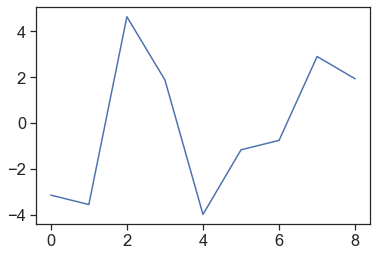

In [2119]:
plt.plot(act_matrix[:,0])

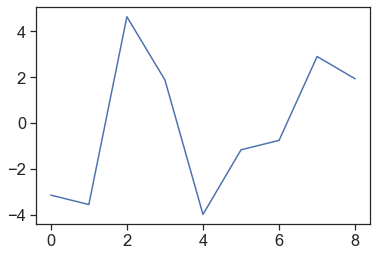

In [2120]:
plt.plot(act_matrix[:,0])

[[ 1.         -0.03167788]
 [-0.03167788  1.        ]]


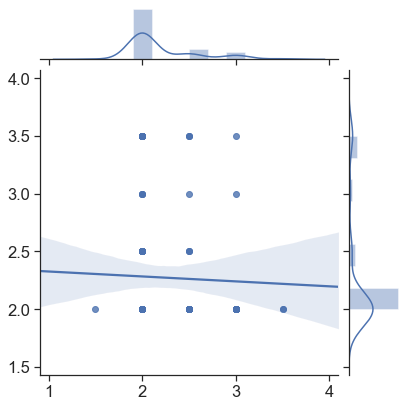

In [883]:
seaborn.jointplot(res_t1[:,0],res_t2[:,0],kind='reg')
print(np.corrcoef(res_t1[:,0],res_t2[:,0]))